In [45]:
import os
import numpy as np
import tensorflow as tf

from PIL import Image
from matplotlib import pyplot as plt

In [46]:
from efficient_det.losses import focal_loss, smooth_l1
from efficient_det.models.efficient_det import my_init
from efficient_det.utils.visualization import draw_boxes
from efficient_det.utils.parser import get_file_names_for_dataset
from efficient_det.utils.anchors import generate_anchors_for_batch
from efficient_det.layers.filter_predictions import get_detections
from efficient_det.preprocessing.generator import FruitDatasetGenerator

In [47]:
def convert_to_numpy(boxes, scores, labels):
    return boxes.numpy(), scores.numpy(), labels.numpy()

In [48]:
# set path to dataset
dataset_path = '../voc_data/'
val_files = get_file_names_for_dataset(name='val', path=dataset_path)

annotations_path = os.path.join(dataset_path, "Annotations/")
image_path = os.path.join(dataset_path, "JPEGImages/")

### Generate validation data generator

In [49]:
val_generator = FruitDatasetGenerator(file_names=val_files, 
                                      annotations_path=annotations_path, 
                                      image_path=image_path)

### Load trained model

In [50]:
# set path to saved model
load_path = "../best_model/best_trained_model.h5"
loaded_model = tf.keras.models.load_model(load_path, custom_objects={'focal_loss': focal_loss, 'smooth_l1': smooth_l1, 'my_init':my_init})

### Sample image and preprocess

In [51]:
# sample random image
random_number = np.random.randint(0, len(val_files))

image_name = val_generator.file_names[random_number]
print(image_name)
image    = val_generator.load_image(random_number)
draw_image = image.copy()

# preprocess image 
h, w = image.shape[:2]
image, scale, offset_h, offset_w = val_generator.preprocess_image(image)

Mango001522.png


### Run detection

In [54]:
anchors_batch = generate_anchors_for_batch(1, val_generator.anchors)
image = tf.expand_dims(image, axis=0)
print(image.shape)
regression, classification = loaded_model(image)

(1, 1, 512, 512, 3)


ValueError: Input 0 is incompatible with layer functional_1: expected shape=(None, 512, 512, 3), found shape=(1, 1, 512, 512, 3)

In [53]:
boxes, scores, labels = get_detections(regression, classification, anchors_batch, val_generator.image_shape)
boxes, scores, labels = convert_to_numpy(boxes, scores, labels)

boxes[:, :, 0] = boxes[:, :, 0] - offset_w
boxes[:, :, 2] = boxes[:, :, 2] - offset_w
boxes[:, :, 1] = boxes[:, :, 1] - offset_h
boxes[:, :, 3] = boxes[:, :, 3] - offset_h

boxes /= scale
boxes[:, :, 0] = np.clip(boxes[:, :, 0], 0, w - 1)
boxes[:, :, 1] = np.clip(boxes[:, :, 1], 0, h - 1)
boxes[:, :, 2] = np.clip(boxes[:, :, 2], 0, w - 1)
boxes[:, :, 3] = np.clip(boxes[:, :, 3], 0, h - 1)

### Draw image

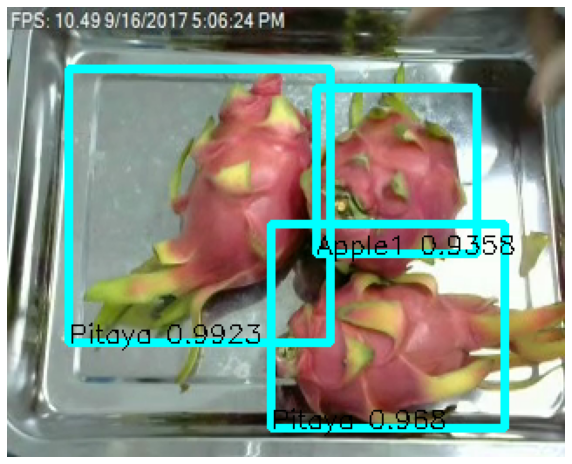

In [10]:
draw_image = draw_boxes(draw_image, boxes, scores, labels, threshold=0.6) # just draw boxes above this threshold

draw = Image.fromarray(draw_image)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(draw)
plt.show()